<a href="https://colab.research.google.com/github/minhanh15/MinhAnh_HDS_Blog/blob/main/Week-03-Exercise02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://drive.google.com/uc?export=view&id=1DXUVHxd4t15mfuqMgMCLnsP4jWVI5EWz)

---
<br>
© 2022 Copyright The University of New South Wales - CRICOS 00098G

**Author**: Oscar Perez-Concha: o.perezconcha@unsw.edu.au

**Contributors/Co-authors**: Marta Fredes-Torres, Zhisheng (Sandy) Sa and Matthew Sainsbury-Dale.

# Week 3: Model Evaluation and Improvement
# Exercise 2: Cross-Validation for hyper-parameter tuning using GridSearchCV

<b>Goal/Research question:</b> <font color=green> <b> To build a predictive algorithm to predict readmission to hospital 30 days after discharge. In particular, this exercise will tune the hyper-parameter C (remember that $(\alpha =  C = \frac {1}{\lambda})$.) of our predictive algorithm (Lasso).</b></font>

# 1. Introduction

## 1.1. Aims of the Exercise:
 1. <font color=green> To become familiar with a validation set to find the best hyper-parameters of a model. Remember that the **hyper-parameters** are **defined by the user**, whereas parameters (e.g. beta coefficients in logistic regression) are found automatically by fitting model.</font>
 2. To become familiar with a grid search: the most commonly used method for tuning hyper-parameters is via a grid search, which entails testing many combinations of the hyper-parameters of interest.
 3. To become familiar with k-CV and grid search
 4. To become familiar with Python pipelines

 
It aligns with all of the learning outcomes of our course: 

1.	Distinguish a range of task specific machine learning techniques appropriate for Health Data Science.
2.	Design machine learning tasks for Health Data Science scenarios.


Follow the instructions given and if you have any questions, please use the **Comment section** in **Open Learning**. 

In [1]:
import sys
import numpy as np
import pandas as pd
from IPython.display import display


In [2]:
# Ignore only Future Warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mount Google Drive
# We do not need to run this cell if you are not running this notebook in Google Colab

if 'google.colab' in str(get_ipython()):
    from google.colab import drive # import drive from Gogle colab
    root = '/content/drive'     # default location for the drive
    # print(root)                 # print content of ROOT (Optional)
    drive.mount(root)
else:
    print('Not running on CoLab')

Mounted at /content/drive


In [4]:
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    # EDIT THE PROJECT PATH IF DIFFERENT WITH YOUR ONE
    project_path = Path(root) / 'My Drive' /'HDS'/ 'HDAT9500' / 'week03'

    # OPTIONAL - set working directory according to your google drive project path
    # import os
    # Change directory to the location defined in project_path
    # os.chdir(project_path)
else:
    project_path = Path()

# 2. Docstring: 

Create a docstring with the variables and constants that you will use in this exercise (data dictionary) and the purpose of your program. It is expected that you choose informative variable names and document your program (both docstrings and comments).

<b> Write the answer here:</b>
#####################################################################################################################

(double-click here)


#####################################################################################################################

# 3. Load the diabetes data set 

As we explained in the previous exercise, we already cleaned and created dummy variables for the diabetes dataset. In the Exercise 1 of Chapter 2 we saved this 'prepared' dataset using `pickle`. Now, we will load this data using 'pickle' ([more information](https://docs.python.org/3/library/pickle.html)). In this case, we will read it from last week's folder. You will have to change the path according to the folder where you stored your `hospital_data.pickle`.

In [5]:
import pickle
pickle_path = Path(root) / 'My Drive' /'HDS'/ 'HDAT9500' / 'week02' /'hospital_data.pickle' 

# Load dataset stored in pickle in Exercise 1
with open(pickle_path, 'rb') as data:
    hospital = pickle.load(data)

pd.set_option('display.max_columns', 100)
hospital.head()

,los,Age,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_outpatient,sex_Female,sex_Male,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,group_name_1_Blood_&_immune,group_name_1_CNS,group_name_1_Cancer,group_name_1_Cardiac_&_circulatory,group_name_1_Digestive,group_name_1_Endocrine,group_name_1_Infectious,group_name_1_Mental_&_Substance,group_name_1_Other,group_name_1_Respiratory,group_name_2_Blood_&_immune,group_name_2_CNS,group_name_2_Cancer,group_name_2_Cardiac_&_circulatory,group_name_2_Digestive,group_name_2_Endocrine,group_name_2_Infectious,group_name_2_Mental_&_Substance,group_name_2_Other,group_name_2_Respiratory,group_name_3_Blood_&_immune,group_name_3_CNS,group_name_3_Cancer,group_name_3_Cardiac_&_circulatory,group_name_3_Digestive,group_name_3_Endocrine,group_name_3_Infectious,group_name_3_Mental_&_Substance,group_name_3_Other,group_name_3_Respiratory,discharge_disposition_grouped_Discharged to home,discharge_disposition_grouped_Home health service,discharge_disposition_grouped_Left AMA,discharge_disposition_grouped_Not available/Null,discharge_disposition_grouped_Other,discharge_disposition_grouped_Short term hospital,discharge_disposition_grouped_Transferred to ICF,discharge_disposition_grouped_Transferred to SNF,admission_source_grouped_Clinic Referral,admission_source_grouped_Emergency Room,admission_source_grouped_Not available/Null,admission_source_grouped_Other,admission_source_grouped_Physician Referral,admission_source_grouped_Transfer from SNF,admission_source_grouped_Transfer from another health care facility,admission_type_grouped_Elective,admission_type_grouped_Emergency,admission_type_grouped_Not Available/Null,admission_type_grouped_Trauma Centre,admission_type_grouped_Urgent,readmission
0,2,79,9,38,0,12,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,no
1,5,59,8,49,0,16,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,no
2,2,33,5,62,0,15,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,no
3,6,42,9,77,0,30,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,no
4,1,62,7,13,5,6,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,no


# 4. Hyper-parameter tuning: Grid Search with Cross-Validation (GridSearchCV)

Remember that:
    

---


1. Cross-validation is just a method to better estimate the performance of a model.
2. Cross-validation can be used either:


a. To just compute the performance of a model using different partitions of training and test sets and/or different hyper-parameters.

b. To compute the performance of a model using different partitions of training and test sets and/or different hyper-parameters AND to select the best resulting model out of that process. We will see this second option in this exercise.


---



The most commonly used method for tuning hyper-parameters is via a grid search, which entails testing many combinations of the hyper-parameters of interest.<p>
    
We want to combine the benefits of cross-validation with the grid search. We will seek to find the model with the best accuracy by using cross-validation. We will use the `sklearn.model_selection.GridSearchCV` function from sklearn ([More information](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))
    


---

We have one hyper-parameter that we would like to tune:
C, ($C=\alpha=1/\lambda$)
<p>

--- 

Let's say we want to try:
C = 0.001, 0.01, 0.1, 1, 10, 100. 

---

Please note that we can tune multiple hyper-parameters, including class weight, C, penalty, among others. In this exercise, we will demonstrate how to use grid search to tune only one parameter, 'C'. In addition, we will choose **L1 regularisation (Lasso) for this problem**. Feel free to add other hyper-parameters and evaluate if the model improves.

---

## 4.1 Splitting the feature variables from the response

In this step, we will also convert responses to binary for later steps.

In [6]:
# Dividing my dataset in X and y (outcome)
X = hospital.drop(axis=1, columns=['readmission'])
y = hospital['readmission']

In [7]:
# Sanity check
display(X[:][:5])
X.shape

,los,Age,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_outpatient,sex_Female,sex_Male,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,group_name_1_Blood_&_immune,group_name_1_CNS,group_name_1_Cancer,group_name_1_Cardiac_&_circulatory,group_name_1_Digestive,group_name_1_Endocrine,group_name_1_Infectious,group_name_1_Mental_&_Substance,group_name_1_Other,group_name_1_Respiratory,group_name_2_Blood_&_immune,group_name_2_CNS,group_name_2_Cancer,group_name_2_Cardiac_&_circulatory,group_name_2_Digestive,group_name_2_Endocrine,group_name_2_Infectious,group_name_2_Mental_&_Substance,group_name_2_Other,group_name_2_Respiratory,group_name_3_Blood_&_immune,group_name_3_CNS,group_name_3_Cancer,group_name_3_Cardiac_&_circulatory,group_name_3_Digestive,group_name_3_Endocrine,group_name_3_Infectious,group_name_3_Mental_&_Substance,group_name_3_Other,group_name_3_Respiratory,discharge_disposition_grouped_Discharged to home,discharge_disposition_grouped_Home health service,discharge_disposition_grouped_Left AMA,discharge_disposition_grouped_Not available/Null,discharge_disposition_grouped_Other,discharge_disposition_grouped_Short term hospital,discharge_disposition_grouped_Transferred to ICF,discharge_disposition_grouped_Transferred to SNF,admission_source_grouped_Clinic Referral,admission_source_grouped_Emergency Room,admission_source_grouped_Not available/Null,admission_source_grouped_Other,admission_source_grouped_Physician Referral,admission_source_grouped_Transfer from SNF,admission_source_grouped_Transfer from another health care facility,admission_type_grouped_Elective,admission_type_grouped_Emergency,admission_type_grouped_Not Available/Null,admission_type_grouped_Trauma Centre,admission_type_grouped_Urgent
0,2,79,9,38,0,12,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,5,59,8,49,0,16,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,33,5,62,0,15,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,6,42,9,77,0,30,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,62,7,13,5,6,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


(69267, 69)

In [8]:
# Sanity Checks:
print('******************************************')
print('y - Yes values =', sum(i =='yes' for i in y))
print('y - No values =', sum(i =='no' for i in y))
print('******************************************\n')

# Create y_binary
y_binary = [0 if x=='no' else 1 for x in y]

# Sanity Checks:
print('\n******************************************')
print('y_binary - 1 values =', sum(i ==1 for i in y_binary))
print('y_binary - 0 values =', sum(i ==0 for i in y_binary))
print('******************************************')

******************************************
y - Yes values = 11919
y - No values = 57348
******************************************


******************************************
y_binary - 1 values = 11919
y_binary - 0 values = 57348
******************************************


## 4.2  Split the whole dataset into a train and a test set (20% of the total)
Now let's split the data into a training and test set. We will include the optional argument `stratify = y` to preserve the ratio between readmission = yes to readmission = no. 

In [9]:
from sklearn.model_selection import train_test_split
# Split X and y into 80% train and 20% test data (roughly), set random state for reproducibility and stratify responses
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=0, stratify = y)

## 4.3 Define the Pipeline

As in exercise 1, we will have to use a pipeline in order to also standardise the features for each iteration of the cross-validation.

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='brown'> Question 1: Define the scaler we will use, and the estimator. As before, choose the scaler ("Transform") to be StandardScaler(), and the estimator ("Estimator") to be L1 Logistic Regression. </font>

To read about Pipelines:
1. [sckit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
2. [An simple example of pipeline](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)


In [10]:
# Write Python Code Here:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 

# Scaler/Standardisation
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

# Classification Model
class_weight_dict={0:0.4, 1:0.6}
Log_L1 = LogisticRegression(C = 0.5, penalty = 'l1',  class_weight = class_weight_dict, solver='liblinear')

# PipeLine: 
pipe = Pipeline([('Transform', Scaler), ('Estimator', Log_L1)])

<div class="alert alert-block alert-warning">**End Activity**</div>

## 4.4 Define the hyper-parameters grid

In [11]:
#Defining the hyper-parameters grid:
param_grid = {'Estimator__C': [0.001, 0.01, 0.1, 1, 10, 100]}
              
print("Parameter grid:")
print("C: {}".format(param_grid['Estimator__C']))

Parameter grid:
C: [0.001, 0.01, 0.1, 1, 10, 100]


Remember that we are going to use a pipeline. In this case, there are two processes that are executed for each iteration of the cross-validation for hyper-parameter tuning:
1. First, the standardisation of the features, 
2. Then, the fitting of the logistic model. 

This means that we have to indicate to which of these processes our hyper-parameter grid belongs.

Notice above that we have named our logistic model 'Estimator'. This means we can designate its hyper-parameters by naming the parameter grid: `Estimator__'parameter_name'`. **For example, we tell the computer that C is meant for the logistic regression estimator by defining it as 'Estimator__C' in the param_grid.**

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='brown'> Question 2: Initialise the GridSearchCV class by passing it the pipeline we have created, *pipe*, our paramater grid, *param_grid*, and specifying the number of folds. We must consider the computational complexity of the algorithm, so we can't set cv too high. In this case, let's choose 5 folds.</font>

The default score for the `GridSearchCV` we defined above is **accuracy**. 

Different scoring measures can be used in the grid search. This can be a simple string or you can pass a list of values to use as multiple evaluation metrics, with the results for each metric viewed through cv_results_. If multiple scoring metrics are set then the refit parameter needs to be set to tell the function which scorer will be used to evaluate the best parameter settings.

For example, we could extract the F1-score of our GridSearchCV by using the command: **`GridSearchCV(pipeline, param_grid,...,scoring='f1')`**

[More information](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html?highlight=cross_validate#sklearn.model_selection.cross_validate)

In [12]:
# Write Python Code Here:

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid, cv = 5)

<div class="alert alert-block alert-warning">**End Activity**</div>

## 4.5 Find the best hyper-parameters

Now we train the grid_search object. Note that grid_search behaves similarly to other classifiers, in the sense that we can use the methods fit, predict and score with it. When we use fit, it performs the grid cross-validation we designed during its initialisation.

**Please note that the following code takes a while to run**:

In [13]:
grid_search.fit(X_train, y_train)

print("Best hyper-parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Best hyper-parameters: {'Estimator__C': 1}
Best cross-validation score: 0.9765


**To have greater clarity of our results, we proceed to analyse the heatmap.**

Let's visualise the mean cross-validation f1-score as a function of the parameter 'C'.

Text(0.5, 47.24444444444444, 'mean_test_score')

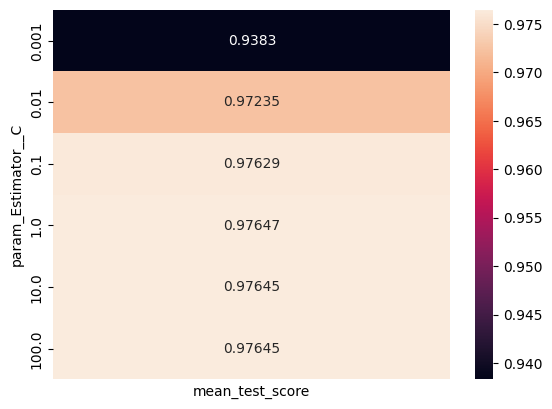

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings; warnings.simplefilter('ignore') #prevent warnings

# Creating DataFrame with GridSearchCV results. df stands for Dataframe
df_gridsearch = pd.DataFrame(grid_search.cv_results_)

max_scores = df_gridsearch.groupby(['param_Estimator__C']).max()
max_scores = max_scores.unstack()[['mean_test_score']]
max_scores.fillna(value=np.nan, inplace=True)

sns.heatmap(max_scores.mean_test_score.to_frame().astype(float), annot=True, fmt='.5g',xticklabels="")
plt.xlabel("mean_test_score")

## 4.6 Evaluate on the performance of the resulting model

<font color=red> **Very very important:** Recall that to this point we have not used the test set</font> - only the training set was used for tuning the hyper-parameters. As you can see, we went from step 6 (hyper-parameter tuning), back to step 4 (once we selected the best hyper-parameteres, we trained the model with those hyper-parameters); subsequently, we move to step 5 (Evaluation of the model).</font>


<font color=green> **Very very important:** "Fitting the GridSearchCV object not only searches for the best hyper-parameters, but also
automatically fits a new model on the whole training dataset with the hyper-parameters that
yielded the best cross-validation performance".

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='brown'> Question 3: Calculate confusion matrix, accuracy, recall, precision and f1 score. Comment on the results below </font>
<font color='green'> Tip: read [GridSerchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) </font> 

<font color='green'>Do we need to scale the test set? Yes, we do, but we do not have to do much. When we apply `.predict` on new data using  our `grid_search(pipeline,...)` object, all the steps defined in the `pipeline` will be applied automatically, including the scaling, which was the first step. Remember our `pipeline` was defined as `pipeln = Pipeline([('Transform', standard_scaler), ('Estimator', log_reg)])`.

In [28]:
# Write Python code here:

import sklearn.metrics as metrics

# Predict labels for the test set
y_pred = grid_search.predict(X_test)

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# Calculate recall
recall = metrics.recall_score(y_test, y_pred)

# Calculate precision
precision = metrics.precision_score(y_test, y_pred)

# Calculate F1 score
f1_score = metrics.f1_score(y_test, y_pred)

# Print the results
print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

Confusion Matrix:
 [[11262   208]
 [  110  2274]]
Accuracy: 0.9770463404071026
Recall: 0.9538590604026845
Precision: 0.9161966156325544
F1 Score: 0.934648581997534


<b> Write your thoughts here:</b>
#####################################################################################################################



#####################################################################################################################

© 2022 Copyright The University of New South Wales - CRICOS 00098G